# Import libraries and instantiate dataframe

In [1]:
import pandas as pd
import json

frames = []
for i in range(0, 10):
    df = pd.read_json('../data/output/match/output_%s.json' % i)
    frames.append(df)

df = pd.concat(frames)

# Analysis of exceptions

## Create exceptions dataframe

In [3]:
exceptions = df['exception']==True

exceptionsDf = df[exceptions]

exceptionsDf.head()


,exception,regex,matchingInputPairs,nonMatchingInputPairs,outputExceptionStackTrace,inputExceptionStackTrace
10,True,None,None,None,{'message': 'Invalid pattern '\u{1D306}' at of...,"{'exceptionThrownBy': 'Python', 'exception': '..."
17,True,None,None,None,{'message': 'Invalid pattern '\$\Q$k\E' at off...,"{'exceptionThrownBy': 'Python', 'exception': '..."
30,True,None,None,None,{'message': 'Invalid pattern ' `[^`]*? #...,"{'exceptionThrownBy': 'Python', 'exception': '..."
159,True,None,None,None,{'message': 'Invalid pattern '#.*\Q$keyword\E ...,"{'exceptionThrownBy': 'Python', 'exception': '..."
164,True,None,None,None,{'message': 'Invalid pattern 'DeviceID: (?P<de...,None


Normalize exception stacktrace to seperate dataframe for analysis

In [5]:
normalizedExceptionsDf = pd.json_normalize(exceptionsDf['outputExceptionStackTrace'])
normalizedExceptionsDf.head()

,message,regex,source
0,Invalid pattern '\u{1D306}' at offset 3. Insuf...,\u{1D306},System.Text.RegularExpressions
1,Invalid pattern '\$\Q$k\E' at offset 4. Unreco...,\$\Q$k\E,System.Text.RegularExpressions
2,Invalid pattern '\n `[^`]*? # The opening...,\n `[^`]*? # The opening backtick on a pl...,System.Text.RegularExpressions
3,Invalid pattern '#.*\Q$keyword\E isa ($CLASS)'...,#.*\Q$keyword\E isa ($CLASS),System.Text.RegularExpressions
4,Invalid pattern 'DeviceID: (?P<deviceID>[0-9]+...,DeviceID: (?P<deviceID>[0-9]+),System.Text.RegularExpressions


In [7]:
import re
def get_sub_category(row):
    x = re.search("(?:[A-Za-z\\(\)'\-{,}+\[\]]+ ){2,5}[A-Za-z\\(\)'){a-z}+\[\]]+.$", row.message)
    if x:
        if 'Unknown property' in x.group(0):
            return 'Unknown property'
        elif 'Reference to undefined group name' in x.group(0):
            return 'Reference to undefined group name'
        elif 'in character range' in x.group(0):
            return 'Cannot include class {x} in character range.'
        else:
            return x.group(0)
    else:
        return None

def get_main_category(row):
    x = re.search("(?:[A-Za-z]+ ){2}", row.message)
    if x: 
        return x.group(0)
    else:
        return None

normalizedExceptionsDf['sub_category'] = normalizedExceptionsDf.apply (lambda row: get_sub_category(row), axis=1)
normalizedExceptionsDf['category'] = normalizedExceptionsDf.apply (lambda row: get_main_category(row), axis=1)

In [52]:
normalizedExceptionsDf['sub_category'].unique().size



22

In [78]:
normalizedExceptionsDf['sub_category'].value_counts().sum()

13120

In [79]:
counts = normalizedExceptionsDf['category'].value_counts().to_dict()
counts

{'Invalid pattern ': 17977, 'Index was ': 1}

In [80]:
normalizedExceptionsDf['sub_category'].value_counts().to_dict()

{'Unrecognized grouping construct.': 5432,
 'Insufficient hexadecimal digits.': 3016,
 "Not enough )'s.": 1538,
 'Unknown property': 748,
 "Nested quantifier '+'.": 746,
 'Unterminated [] set.': 531,
 'p{X} character escape.': 351,
 "Too many )'s.": 226,
 'Quantifier {x,y} following nothing.': 199,
 '[x-y] range in reverse order.': 152,
 'Reference to undefined group name': 66,
 'Cannot include class {x} in character range.': 32,
 'Unrecognized control character.': 31,
 "Nested quantifier '{'.": 22,
 'must begin with a word character.': 16,
 'last element in a character class.': 7,
 'named back reference.': 3,
 'at end of pattern.': 1,
 'outside the bounds of the array.': 1,
 ') ) reference to undefined group.': 1,
 'Missing control character.': 1}

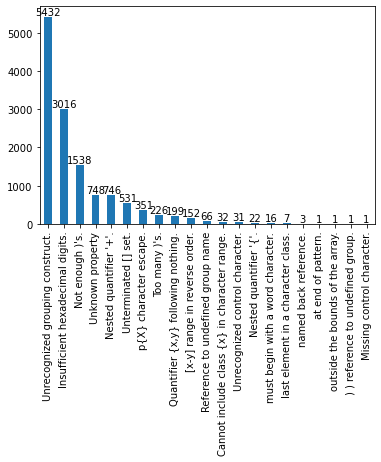

In [53]:
ax = normalizedExceptionsDf['sub_category'].value_counts().plot.bar()
for container in ax.containers:
    ax.bar_label(container)


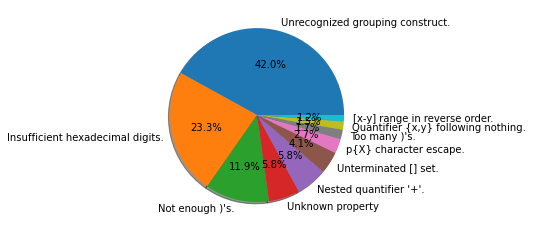

In [60]:
ax = normalizedExceptionsDf['sub_category'].value_counts().head(10).plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

## Analysis of Unrecognized grouping construct exception

In [82]:
unrecognized_grouping_construct = normalizedExceptionsDf['sub_category']=='Unrecognized grouping construct.'

unrecognized_grouping_construct_df = normalizedExceptionsDf[unrecognized_grouping_construct]

unrecognized_grouping_construct_df.head(2)

,message,regex,source,sub_category,category
4,Invalid pattern 'DeviceID: (?P<deviceID>[0-9]+...,DeviceID: (?P<deviceID>[0-9]+),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern
5,"Invalid pattern '""(?P<Major>\d*?)\.(?P<Minor>\...","""(?P<Major>\d*?)\.(?P<Minor>\d*?)\.(?P<Patch>\...",System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern


In [104]:
# retrieve regex pattern
def get_grouping_construct(row):
    x = re.search("\(\?[{A-Za-z}*\:]", row.message)
    if x:
        return x.group(0)
    else:
        return None

unrecognized_grouping_construct_df['grouping_construct'] = normalizedExceptionsDf.apply (lambda row: get_grouping_construct(row), axis=1)
unrecognized_grouping_construct_df.head()

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_51191/2320901100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrecognized_grouping_construct_df['grouping_construct'] = normalizedExceptionsDf.apply (lambda row: get_grouping_construct(row), axis=1)


,message,regex,source,sub_category,category,grouping_construct,is_grouping_construct_naming_error
4,Invalid pattern 'DeviceID: (?P<deviceID>[0-9]+...,DeviceID: (?P<deviceID>[0-9]+),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True
5,"Invalid pattern '""(?P<Major>\d*?)\.(?P<Minor>\...","""(?P<Major>\d*?)\.(?P<Minor>\d*?)\.(?P<Patch>\...",System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True
14,Invalid pattern 'firstInstallTime=(?P<time>.*)...,firstInstallTime=(?P<time>.*),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True
17,Invalid pattern '(?P<msec>^0?\.\d+) (?P<sec>\d...,(?P<msec>^0?\.\d+) (?P<sec>\d+)$,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True
25,Invalid pattern '^(?P<station_name>[^_]+)_(?P<...,^(?P<station_name>[^_]+)_(?P<channel_nums>0\+1...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True


In [105]:
unrecognized_grouping_construct_df.describe()

,message,regex,source,sub_category,category,grouping_construct,is_grouping_construct_naming_error
count,5432,5432,5432,5432,5432,5338,5432
unique,5432,5432,1,1,1,12,2
top,Invalid pattern 'DeviceID: (?P<deviceID>[0-9]+...,DeviceID: (?P<deviceID>[0-9]+),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?P,True
freq,1,1,5432,5432,5432,4695,5338


In [106]:
unrecognized_grouping_construct_df['grouping_construct'].value_counts().sum()

5338

In [107]:
def is_naming_error(row):
    if row.grouping_construct == None:
        return False
    else:
        return True

unrecognized_grouping_construct_df['is_grouping_construct_naming_error'] = unrecognized_grouping_construct_df.apply (lambda row: is_naming_error(row), axis=1)

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_51191/2611618959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrecognized_grouping_construct_df['is_grouping_construct_naming_error'] = unrecognized_grouping_construct_df.apply (lambda row: is_naming_error(row), axis=1)


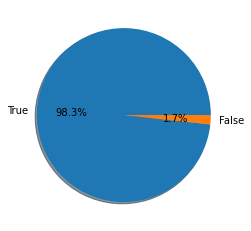

In [108]:
ax = unrecognized_grouping_construct_df['is_grouping_construct_naming_error'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

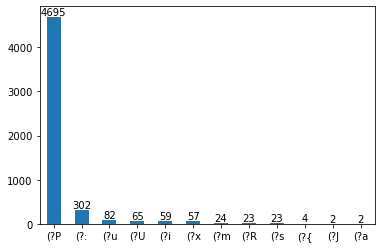

In [109]:
ax = unrecognized_grouping_construct_df['grouping_construct'].value_counts().plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

## Analysis of Insufficient hexadecimal digits error

In [110]:
insufficient_digits_errors = normalizedExceptionsDf['sub_category']=='Insufficient hexadecimal digits.'

insufficient_digits_error_df = normalizedExceptionsDf[insufficient_digits_errors]

insufficient_digits_error_df.head()

,message,regex,source,sub_category,category
0,Invalid pattern '\u{1D306}' at offset 3. Insuf...,\u{1D306},System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
9,Invalid pattern '(<S>[Aa]r<\/S> <D>(?:\x{e1}r|...,(<S>[Aa]r<\/S> <D>(?:\x{e1}r|bhur|a)<\/D> <E[^...,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
18,Invalid pattern '^[\x{9}\x{A}\x{D}\x{20}-\x{7E...,^[\x{9}\x{A}\x{D}\x{20}-\x{7E}\x{A0}-\x{D7FF}\...,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
20,Invalid pattern '\x{0637}' at offset 3. Insuff...,\x{0637},System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
23,Invalid pattern '\x{A0}+' at offset 3. Insuffi...,\x{A0}+,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
24,Invalid pattern '(<E[^>]*><S>[Ii] ngach<\/S> <...,"(<E[^>]*><S>[Ii] ngach<\/S> <A pl=""n"" gnt=""n"">...",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
28,Invalid pattern '[\x{A0}\x{2000}-\x{200B}]' at...,[\x{A0}\x{2000}-\x{200B}],System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
35,Invalid pattern '(?<![<>])(<T>[Aa]n<\/T> <N pl...,"(?<![<>])(<T>[Aa]n<\/T> <N pl=""n"" gnt=""n"" gnd=...",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
36,"Invalid pattern '^((\x{20}{6,})((\*\x{20}?){5}...","^((\x{20}{6,})((\*\x{20}?){5})\s*)$",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern
43,Invalid pattern '(\x{1094}|\x{1095})' at offse...,(\x{1094}|\x{1095}),System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern


In [114]:
def get_invalid_character(row):
    x = re.search("(\\\\x)|(\\\\u)|(\\\\x)", row.regex)
    if x:
        return x.group(0)
    else:
        return "other character"

insufficient_digits_error_df['invalid_pattern'] = insufficient_digits_error_df.apply (lambda row: get_invalid_character(row), axis=1)
insufficient_digits_error_df.head()

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_51191/2977187146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insufficient_digits_error_df['invalid_pattern'] = insufficient_digits_error_df.apply (lambda row: get_invalid_character(row), axis=1)


,message,regex,source,sub_category,category,invalid_pattern
0,Invalid pattern '\u{1D306}' at offset 3. Insuf...,\u{1D306},System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\u
9,Invalid pattern '(<S>[Aa]r<\/S> <D>(?:\x{e1}r|...,(<S>[Aa]r<\/S> <D>(?:\x{e1}r|bhur|a)<\/D> <E[^...,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
18,Invalid pattern '^[\x{9}\x{A}\x{D}\x{20}-\x{7E...,^[\x{9}\x{A}\x{D}\x{20}-\x{7E}\x{A0}-\x{D7FF}\...,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
20,Invalid pattern '\x{0637}' at offset 3. Insuff...,\x{0637},System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
23,Invalid pattern '\x{A0}+' at offset 3. Insuffi...,\x{A0}+,System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
24,Invalid pattern '(<E[^>]*><S>[Ii] ngach<\/S> <...,"(<E[^>]*><S>[Ii] ngach<\/S> <A pl=""n"" gnt=""n"">...",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
28,Invalid pattern '[\x{A0}\x{2000}-\x{200B}]' at...,[\x{A0}\x{2000}-\x{200B}],System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
35,Invalid pattern '(?<![<>])(<T>[Aa]n<\/T> <N pl...,"(?<![<>])(<T>[Aa]n<\/T> <N pl=""n"" gnt=""n"" gnd=...",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
36,"Invalid pattern '^((\x{20}{6,})((\*\x{20}?){5}...","^((\x{20}{6,})((\*\x{20}?){5})\s*)$",System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x
43,Invalid pattern '(\x{1094}|\x{1095})' at offse...,(\x{1094}|\x{1095}),System.Text.RegularExpressions,Insufficient hexadecimal digits.,Invalid pattern,\x


In [115]:
insufficient_digits_error_df['invalid_pattern'].describe()

count     3016
unique       2
top         \x
freq      2810
Name: invalid_pattern, dtype: object

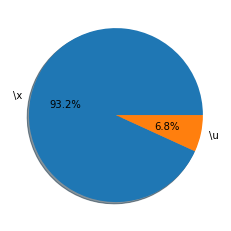

In [113]:
ax = insufficient_digits_error_df['invalid_pattern'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

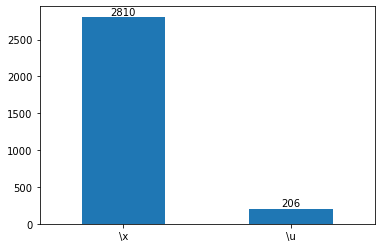

In [93]:
ax = insufficient_digits_error_df['invalid_pattern'].value_counts().plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)


## Analysis of missing closing round bracket
sub category: Not enough )'s 


In [10]:
missing_brackets = normalizedExceptionsDf['sub_category']=="Not enough )'s."

missing_brackets_df = normalizedExceptionsDf[missing_brackets]

missing_brackets_df.head()

,message,regex,source,sub_category,category
2,Invalid pattern '\n `[^`]*? # The opening...,\n `[^`]*? # The opening backtick on a pl...,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
7,Invalid pattern '^[ \t]*(-|\*\**|\u2022)[ \t]+...,^[ \t]*(-|\*\**|\u2022)[ \t]+(,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
15,Invalid pattern '(d+\/(\d+)' at offset 10. Not...,(d+\/(\d+),System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
54,Invalid pattern ''(?:[^\'\\\n\r]|' at offset 1...,'(?:[^\'\\\n\r]|,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
66,Invalid pattern '(?<=\s' at offset 6. Not enou...,(?<=\s,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern


In [13]:
missing_brackets_df.describe()

,message,regex,source,sub_category,category
count,1538,1538,1538,1538,1538
unique,1538,1538,1,1,1
top,Invalid pattern '\n `[^`]*? # The opening...,\n `[^`]*? # The opening backtick on a pl...,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
freq,1,1,1538,1538,1538


## Analysis of unknown property exception

In [15]:
unknown_property = normalizedExceptionsDf['sub_category']=="Unknown property"

unknown_property_df = normalizedExceptionsDf[unknown_property]

unknown_property_df.head(20)

,message,regex,source,sub_category,category
59,Invalid pattern '^(\p{InCJKUnifiedIdeographs}+...,^(\p{InCJKUnifiedIdeographs}+),System.Text.RegularExpressions,Unknown property,Invalid pattern
61,Invalid pattern '.+\.[\p{Alnum}]+' at offset 1...,.+\.[\p{Alnum}]+,System.Text.RegularExpressions,Unknown property,Invalid pattern
62,Invalid pattern '\A[\p{katakana}\s]+\z' at off...,\A[\p{katakana}\s]+\z,System.Text.RegularExpressions,Unknown property,Invalid pattern
93,Invalid pattern '^\p{Alpha}{3}' at offset 10. ...,^\p{Alpha}{3},System.Text.RegularExpressions,Unknown property,Invalid pattern
142,Invalid pattern '^get([\p{Upper}]{1}.*)$|^is([...,^get([\p{Upper}]{1}.*)$|^is([\p{Upper}]{1}.*)$,System.Text.RegularExpressions,Unknown property,Invalid pattern
155,Invalid pattern '^L\(\p{Space}*\p{Alnum}+\p{Sp...,^L\(\p{Space}*\p{Alnum}+\p{Space}*\)$,System.Text.RegularExpressions,Unknown property,Invalid pattern
173,Invalid pattern '[\p{Blank}]+$' at offset 10. ...,[\p{Blank}]+$,System.Text.RegularExpressions,Unknown property,Invalid pattern
178,Invalid pattern '[\p{Alpha}]+://.+' at offset ...,[\p{Alpha}]+://.+,System.Text.RegularExpressions,Unknown property,Invalid pattern
200,Invalid pattern '[\p{Space}]+' at offset 10. U...,[\p{Space}]+,System.Text.RegularExpressions,Unknown property,Invalid pattern
202,Invalid pattern ' \G (\w|_\p{IsAlpha}+) ([0-9]...,"\G (\w|_\p{IsAlpha}+) ([0-9]+)? (r)? ([.\-+,\...",System.Text.RegularExpressions,Unknown property,Invalid pattern


In [22]:
regex_pattern = "(\\\\p{[A-Za-z]*})|(\\\\P{[A-Za-z]*})"

def get_invalid_script(row):
    x = re.search(regex_pattern, row.regex)
    if x:
        return x.group(0)
    else:
        return "other character"

unknown_property_df['invalid_pattern'] = unknown_property_df.apply (lambda row: get_invalid_script(row), axis=1)
unknown_property_df['invalid_pattern'].value_counts()

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_22812/1431162256.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_property_df['invalid_pattern'] = unknown_property_df.apply (lambda row: get_invalid_script(row), axis=1)


\p{Alnum}              45
\p{Alpha}              42
\p{Han}                42
\p{Punct}              35
\p{Word}               34
                       ..
\P{Upper}               1
\p{InEmojiKDDIweb}      1
\p{LOE}                 1
\p{OpenPunctuation}     1
\p{IsDeviation}         1
Name: invalid_pattern, Length: 220, dtype: int64

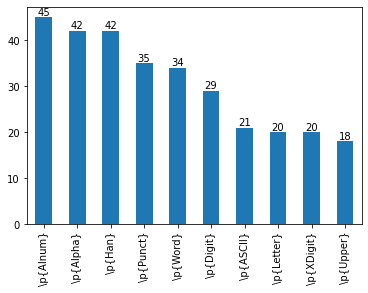

In [35]:
ax = unknown_property_df['invalid_pattern'].value_counts().head(10).plot.bar()

for container in ax.containers:
    ax.bar_label(container)

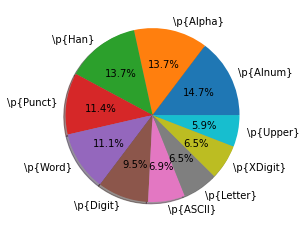

In [51]:
ax = unknown_property_df['invalid_pattern'].value_counts().head(10).plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

In [49]:
import matplotlib.pyplot as plt
from IPython.display import display
unknown_property_df['invalid_pattern'].value_counts().to_csv('../data/output/unkown_property_exception.csv')


# Analysis of matches and non matches

## Analysis of matching pairs

Here we are iterating over all the matching pairs proposed by Egret. When a False value is found for the match property, it means that a non-match case was found in the list of matches. This means behaviour is different than proposed by Egret.


In [83]:
def return_match_type_matching_pairs(row):

    if row.matchingInputPairs and len(row.matchingInputPairs) > 0: 
        for pair in row.matchingInputPairs:
            if pair['match'] == False:
                return 'Non-matches'
            else:
                return 'Matches'
    else:
        return None

df['match_type_matching_pairs'] = df.apply (lambda row: return_match_type_matching_pairs(row), axis=1)

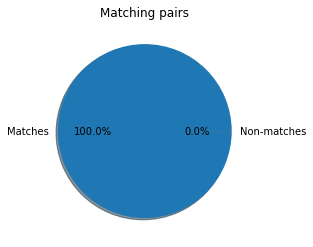

In [84]:
ax = df['match_type_matching_pairs'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.set_title("Matching pairs")
ax.yaxis.set_visible(False)

## Analysis of non matching pairs
In this case, we are iterating over the non-matching input pairs, which contains the non-matches provided by Egret, and the outcome of the .NET's Regex library match() method.

If the property match contains the value of 'True', it means that a match case found. This means that the behaviour is different than Egret proposed.

In [2]:
def return_match_type_non_matching_pairs(row):    
    if row.nonMatchingInputPairs and len(row.nonMatchingInputPairs) > 0: 
        for pair in row.nonMatchingInputPairs:
            if pair['match'] == True:
                return 'Matches'
            else:
                return 'Non-matches'
        
    else:
        return None


df['match_type_non_matching_pairs'] = df.apply (lambda row: return_match_type_non_matching_pairs(row), axis=1)


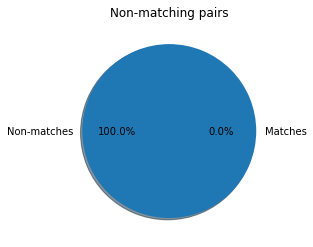

In [5]:
ax = df['match_type_non_matching_pairs'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.set_title("Non-matching pairs")
ax.yaxis.set_visible(False)
for container in ax.containers:
    ax.set_label(container)

In [4]:
df_no_match = df[df['match_type_non_matching_pairs']=='Matches']
df_no_match.head() 

In [90]:
df_no_match.describe()

,exception,regex,matchingInputPairs,nonMatchingInputPairs,outputExceptionStackTrace,inputExceptionStackTrace,match_type_matching_pairs,match_type_non_matching_pairs
count,7643,7643,7643,7643,0,0,7548,7643
unique,1,7643,6425,5888,0,0,1,1
top,False,"(\d+[.,]?\d*)(\+(\d+[.,]?\d*)){1}i",[],"[{'input': '.0', 'match': True}]",NaN,NaN,Matches,Matches
freq,7643,1,95,63,NaN,NaN,7548,7643


In [88]:
sample = df_no_match.sample(n=10)

In [89]:
sample.to_json('../data/output/samples_non_matching.json')